In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tensorflow Utils
import tensorflow as tf
import tensorflow_hub as hub

**Loading** **Dataset** : Wine Reviews Dataset

**Source** : Kaggle
**Dataset** : Wine Reviews Dataset

**Link** : https://www.kaggle.com/zynicide/wine-reviews

In [3]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipython-input-3359790117.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [4]:
# dataset overview
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
# Dataset columns
df.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [6]:
# Removing Columns
# Description : Points (label)
df.drop(columns=["Unnamed: 0" ,'country' , 'designation' , 'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'] , inplace=True)

In [7]:
df.head() , df.tail()

(                                         description  points
 0  Aromas include tropical fruit, broom, brimston...      87
 1  This is ripe and fruity, a wine that is smooth...      87
 2  Tart and snappy, the flavors of lime flesh and...      87
 3  Pineapple rind, lemon pith and orange blossom ...      87
 4  Much like the regular bottling from 2012, this...      87,
                                               description  points
 129966  Notes of honeysuckle and cantaloupe sweeten th...      90
 129967  Citation is given as much as a decade of bottl...      90
 129968  Well-drained gravel soil gives this wine its c...      90
 129969  A dry style of Pinot Gris, this is crisp with ...      90
 129970  Big, rich and off-dry, this is powered by inte...      90)

In [8]:
# checking for null values
df.isna().sum()

,0
description,0
points,0


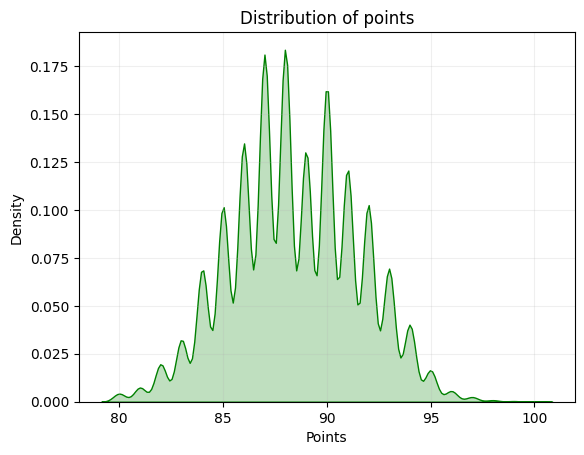

In [9]:
# Plotting the points
sns.kdeplot(df["points"] , color = "green" , fill = True)
plt.title("Distribution of points")
plt.xlabel("Points")
plt.ylabel("Density")
plt.grid(alpha = 0.2)
plt.show()

In [10]:
# new label column
df["quality"] = (df["points"] >= 90).astype(int)

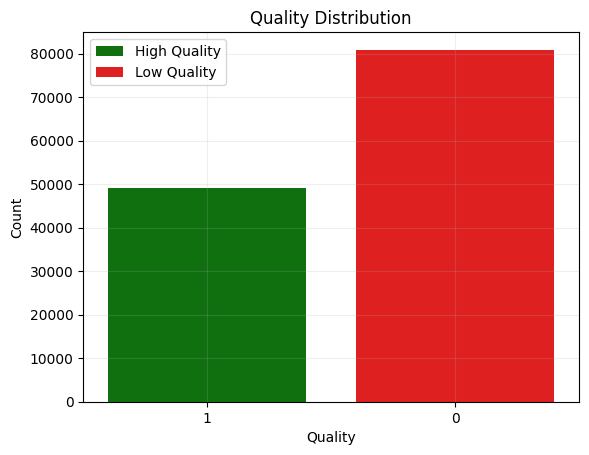

In [11]:
# quality distribution
sns.countplot(x = df[df["quality"] == 1]["quality"] , color = "green" , label = "High Quality")
sns.countplot(x = df[df["quality"] == 0]["quality"] , color = "red" , label = "Low Quality")
plt.title("Quality Distribution")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.grid(alpha = 0.2)
plt.show()

In [12]:
# description : quality

df = df[["description" , "quality"]]

In [13]:
# split : train , valid  , test
# Train : 80% , Valid : 10% , Test : 10%
train , valid , test  = np.split(df.sample(frac = 1) , [int(0.8 * len(df)) , int(0.9 * len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [14]:
def df_to_dataset(dataframe , shuffle = False ,  batch_size = 1024):
  df = dataframe.copy()
  t_label = df.pop("quality") # target label
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df , t_label))
  if shuffle:
    ds = df.shuffle(buffer_size = len(df))

  ds = ds.batch(batch_size=batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)

  return ds

In [15]:
# Changing to dataset pipline
train_ds = df_to_dataset(train)
valid_ds = df_to_dataset(valid)
test_ds = df_to_dataset(test)

In [16]:
# Embedding
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(
    embedding,
    dtype=tf.string,
    input_shape=[],
    trainable=True
)

In [17]:
# preview of the description after converted to dataset , batch
list(train_ds)[0][0]

<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'Simple and ripe, this wine highlights a fruity blend of pineapples, peaches and apricots, punched up with a warming touch of alcohol. Forward and easy drinking with a slightly cloying finish.',
       b'Fresh toast, wooded spice  on the nose is friendly and appealing. On the palate, it works too, with its playful balance of layered spice oak and fresh acidity. The wine will appeal to fans of both oaked and unoaked Chardonnay, and will make a nice addition to the table.',
       b'Made with 80% Sangiovese and 20% Merlot, this opens with aromas of prune, scorched earth, toast and a hint of black currant. On the structured palate, notes of grilled bell pepper, espresso and dried herb accent a core of dried black cherry alongside fine-grained tannins that give it a firm finish.',
       ...,
       b"There's a slightly sweaty note in the nose, but plenty of fruit in the mouth. Blueberry and black cherry, cassis and blue plum gather w

In [18]:
# preview of the description after converted to normalized vectors
hub_layer(list(train_ds)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.3126601 , -0.17860238, -0.00148068, ...,  0.0105657 ,
        -0.33386514, -0.06040689],
       [ 0.31479055, -0.1552235 ,  0.04755927, ..., -0.25054106,
        -0.06093749,  0.08929158],
       [ 0.60064733, -0.12018678, -0.22035347, ...,  0.01135157,
         0.05862828, -0.01452897],
       ...,
       [ 0.48127702, -0.29479796,  0.27806318, ..., -0.07349958,
        -0.05165241, -0.24501377],
       [ 0.13953061, -0.19568765, -0.13061535, ..., -0.15777968,
        -0.075624  , -0.0711525 ],
       [ 0.2444546 , -0.28517178,  0.07304367, ...,  0.08385634,
        -0.13579738,  0.03285486]], dtype=float32)>

In [19]:
# layers
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16 , activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(16 , activation = "relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1 , activation = "sigmoid")
])

ValueError                                Traceback (most recent call last)
/tmp/ipython-input-911868878.py in <cell line: 0>()
      1 # Model
----> 2 model = tf.keras.Sequential([
      3     hub_layer,
      4     tf.keras.layers.Dense(16 , activation = "relu"),
      5     tf.keras.layers.Dropout(0.4),

/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py in __init__(self, layers, trainable, name)
     73         if layers:
     74             for layer in layers:
---> 75                 self.add(layer, rebuild=False)
     76             self._maybe_rebuild()
     77

/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py in add(self, layer, rebuild)
     95                 layer = origin_layer
     96         if not isinstance(layer, Layer):
---> 97             raise ValueError(
     98                 "Only instances of `keras.Layer` can be "
     99                 f"added to a Sequential model. Received: {layer} "

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7ac3e4c9aa90> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

```bash
pip install --upgrade tensorflow==2.15.0 tensorflow_hub==0.16.

```


In [20]:
# Compile
model.compile(
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) ,
              loss = tf.keras.losses.BinaryCrossentropy() ,
              metrics = ["accuracy"]
            )

In [21]:
# Evaluation before training
model.evaluate(train_ds)

102/102 [==============================] - 1s 12ms/step - loss: 0.7259 - accuracy: 0.3785


[0.7259464263916016, 0.3785008192062378]

In [22]:
# Evaluation before training
model.evaluate(valid_ds)

13/13 [==============================] - 0s 11ms/step - loss: 0.7267 - accuracy: 0.3767


[0.7266920208930969, 0.37670230865478516]

In [23]:
# Training the model
history = model.fit(train_ds , epochs = 5 , validation_data = valid_ds)

Epoch 1/5
102/102 [==============================] - 132s 1s/step - loss: 0.6693 - accuracy: 0.5872 - val_loss: 0.5970 - val_accuracy: 0.7154
Epoch 2/5
102/102 [==============================] - 138s 1s/step - loss: 0.5378 - accuracy: 0.7471 - val_loss: 0.4218 - val_accuracy: 0.8093
Epoch 3/5
102/102 [==============================] - 136s 1s/step - loss: 0.4257 - accuracy: 0.8219 - val_loss: 0.3837 - val_accuracy: 0.8232
Epoch 4/5
102/102 [==============================] - 153s 1s/step - loss: 0.3796 - accuracy: 0.8429 - val_loss: 0.3757 - val_accuracy: 0.8276
Epoch 5/5
102/102 [==============================] - 137s 1s/step - loss: 0.3560 - accuracy: 0.8541 - val_loss: 0.3741 - val_accuracy: 0.8289


In [24]:
model.evaluate(test_ds)

13/13 [==============================] - 7s 498ms/step - loss: 0.3675 - accuracy: 0.8321


[0.36747774481773376, 0.8321280479431152]

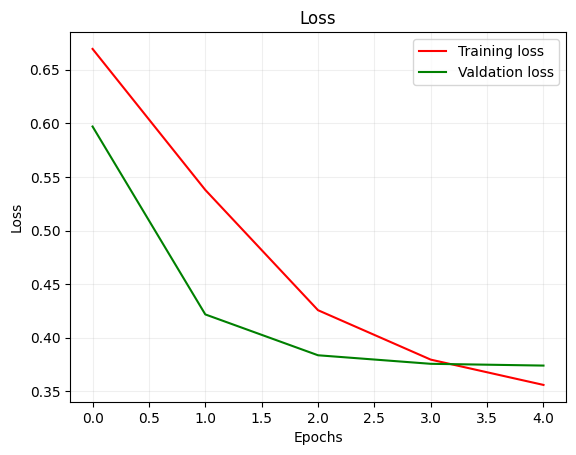

In [28]:
# Loss plot
plt.plot(history.history["loss"] , color = "red")
plt.plot(history.history["val_loss"] , color = "green" )
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(alpha = 0.2)
plt.legend(["Training loss" , "Valdation loss"])
plt.show()

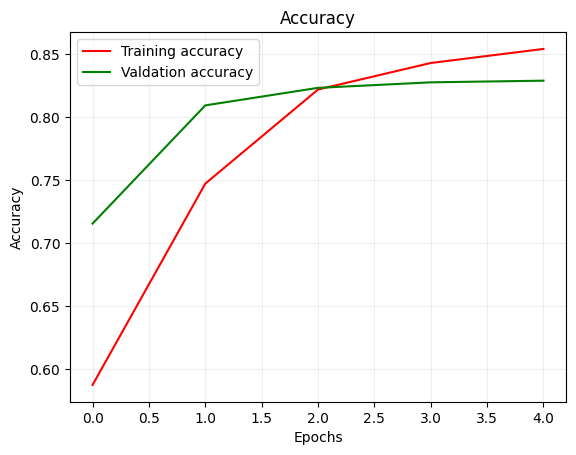

In [29]:
# Accuracy Plot
plt.plot(history.history["accuracy"] , color = "red")
plt.plot(history.history["val_accuracy"] , color = "green" )
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plt.legend(["Training accuracy" , "Valdation accuracy"])
plt.show()

### LSTM

In [31]:
# Tokenizaiton
encoder = tf.keras.layers.TextVectorization(max_tokens = 2000)
encoder.adapt(train_ds.map(lambda text , label : text))

In [32]:
# Vocabs
vocab = np.array(encoder.get_vocabulary())
vocab[:25]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that', 'finish', 'acidity', 'from', 'but', 'tannins'],
      dtype='<U17')

In [36]:
# Lstm Model layers
lstm_model = tf.keras.Sequential([
    encoder , # 1 encoder / Tokenizer
    tf.keras.layers.Embedding(    # 2 token to normalized vectors
      input_dim = len(encoder.get_vocabulary()),
      output_dim = 32,
      mask_zero = True
    ),

    tf.keras.layers.LSTM(32), # RNN ---> LSTM model
    tf.keras.layers.Dense(32 , activation = "relu"), # hidden layer
    tf.keras.layers.Dropout(0.3), # dropout
    tf.keras.layers.Dense(1 , activation = "sigmoid") # output layer
])

In [39]:
# compile
lstm_model.compile(
    tf.keras.optimizers.Adam(learning_rate = 0.001) ,
    tf.keras.losses.BinaryCrossentropy() ,
    metrics = ["accuracy"]
)

In [40]:
# evaluation before training
lstm_model.evaluate(train_ds)
lstm_model.evaluate(valid_ds)

13/13 [==============================] - 3s 198ms/step - loss: 0.6938 - accuracy: 0.4113


[0.693825900554657, 0.41132569313049316]

In [41]:
# Training
history = lstm_model.fit(train_ds , epochs = 5 , validation_data = valid_ds)

Epoch 1/5
102/102 [==============================] - 62s 557ms/step - loss: 0.5407 - accuracy: 0.7118 - val_loss: 0.3882 - val_accuracy: 0.8207
Epoch 2/5
102/102 [==============================] - 46s 455ms/step - loss: 0.3654 - accuracy: 0.8350 - val_loss: 0.3645 - val_accuracy: 0.8358
Epoch 3/5
102/102 [==============================] - 44s 428ms/step - loss: 0.3458 - accuracy: 0.8453 - val_loss: 0.3683 - val_accuracy: 0.8356
Epoch 4/5
102/102 [==============================] - 45s 437ms/step - loss: 0.3394 - accuracy: 0.8485 - val_loss: 0.3616 - val_accuracy: 0.8386
Epoch 5/5
102/102 [==============================] - 45s 443ms/step - loss: 0.3342 - accuracy: 0.8497 - val_loss: 0.3627 - val_accuracy: 0.8375


In [42]:
lstm_model.evaluate(valid_ds)

13/13 [==============================] - 2s 150ms/step - loss: 0.3627 - accuracy: 0.8375


[0.3627319633960724, 0.8375009894371033]